# Prediciendo la supervivencia en Titanic

En esta parte vas a usar diferentes modelos para predecir la supervivencia en Titanic. Utiliza el data set llamado 'titanic.xls'. Estas son las variables:

* name: Nombre del pasajero
* sex: Sexo del pasajero
* age: edad en años
* sibsp: # de hermanos / esposas abordo del Titanic
* parch: # de padres / niños abordo del Titanic
* ticket: Número de Boleto del barco
* fare: Precio del Boleto del barco
* cabin: Número de camarote
* embarked: Puerto de embarcación
* survived: Sobrevivió?

In [1]:
# Librerías estándar
import pandas as pd
import numpy as np
import itertools
import matplotlib.pyplot as plt

# Librerías de Ciencia de Datos
from sklearn.model_selection import learning_curve
from sklearn.model_selection import validation_curve
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics         import confusion_matrix
from sklearn.metrics         import roc_curve
from sklearn.metrics         import roc_auc_score
from sklearn.ensemble        import RandomForestClassifier, ExtraTreesClassifier
from sklearn.neighbors       import KNeighborsClassifier
from sklearn.dummy           import DummyClassifier
from sklearn.linear_model    import LogisticRegression
from sklearn.pipeline        import Pipeline
from sklearn.svm             import SVC
from sklearn.tree            import DecisionTreeClassifier
from sklearn.preprocessing   import StandardScaler
from sklearn.model_selection import cross_val_predict
from sklearn.model_selection import cross_val_score
from sklearn import preprocessing
from sklearn.inspection import permutation_importance

# import seaborn as sns
%matplotlib inline

In [2]:
# Definir funciones útiles
def grafica_matriz_confusion(cm, classes=[0,1], normalize=False, title='Matriz de confusión\n', cmap=plt.cm.Reds):
    """ 
    Función para mostrar la matriz de confusión de un problema de clasificación binario. 
    El parámetro cm puede ser el objeto resultante de ejecutar la función confusion_matrix() de la librería sklearn.
    
    Args:
        cm         matriz de confusión de sklearn
        classes    categorías de la variable target
        normalize  normaliza asignando el parámetro True
        title      string para definir el título para la gráfica
        cmap       mapa de colores
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=0)
    plt.yticks(tick_marks, classes)
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    thresh = cm.max()
    text = [["VN =", "FN ="], ["FP =", "VP ="]]
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, "     {}".format(round (cm[i, j],2)), horizontalalignment="left",
                 color="white" if cm[i, j] > thresh else "black")
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, text[j][i] , horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")
    plt.tight_layout()
    plt.ylabel('Valor real')
    plt.xlabel('Predicción')
    
def grafica_curva_roc(fpr, tpr, title='Curva ROC', note=''):
    """
    Función para graficar la curva ROC
    Los parámetros fpr y tpr son el output de ejecutar la función roc_curve de sklearn
    
    Args:
        fpr        Tasa de falsos positivos 
        tpr        Tasa de verdaderos positivos
        title      sting para definir el título de la gráfica
        note       Nota para mostrar en la gráfica
    """
    plt.figure(1)
    plt.plot([0, 1], [0, 1], 'k--')
    plt.plot(fpr, tpr)
    plt.xlabel('Tasa de falsos positivos ')
    plt.ylabel('Tasa de verdaderos positivos')
    plt.title(title)
    if note: plt.text(0.6, 0.2, note)
    plt.show()
    
## Compara las métricas de los modelos anteriores
def print_metrics(classifier_name, metric_1_list, metric_2_list, metric_3_list, metric_4_list): 
    dash = '-' * 80
    print(dash)
    print('{:<20s}{:<15s}{:<15s}{:<15s}{:<15s}'.format('Clasificador','Efectividad', 'ROC AUC', 'recall', 'precision'))
    print(dash)
    for i in range(len(classifier_name)):
        print('{:<20s}{:<15.3f}{:<15.3f}{:<15.3f}{:<15.3f}'.format(classifier_name[i], metric_1_list[i], metric_2_list[i], metric_3_list[i], metric_4_list[i]))
    print(dash)

## Explora y preprocesa el Data set

In [3]:
# Carga los datos
titanic = pd.read_excel('titanic.xls')
titanic.head(5)

,survived,name,sex,age,sibsp,parch,ticket,fare,cabin,embarked
0,1,"Allen, Miss. Elisabeth Walton",female,29.0000,0,0,24160,211.3375,B5,S
1,1,"Allison, Master. Hudson Trevor",male,0.9167,1,2,113781,151.5500,C22 C26,S
2,0,"Allison, Miss. Helen Loraine",female,2.0000,1,2,113781,151.5500,C22 C26,S
3,0,"Allison, Mr. Hudson Joshua Creighton",male,30.0000,1,2,113781,151.5500,C22 C26,S
4,0,"Allison, Mrs. Hudson J C (Bessie Waldo Daniels)",female,25.0000,1,2,113781,151.5500,C22 C26,S


In [4]:
# Analiza la variable target
dead = titanic[titanic['survived']==0]
survived = titanic[titanic['survived']==1]

print("Sobrevivientes {0}, Muertos {1}".format(len(survived), len(dead)))
print("Sobrevivieron {:.2%}".format(len(survived)/len(titanic)))

Sobrevivientes 500, Muertos 809
Sobrevivieron 38.20%


In [5]:
# Delimita variables a usar. Cuáles tienen sentido?
titanic_features = ['sex', 'age', 'sibsp', 'parch', 'fare']

In [6]:
# Define X e y y transforma variables categóricas con one-hot encoding
X = pd.get_dummies(titanic[titanic_features])
y = titanic['survived']

In [8]:
# Hay valores missing? En caso de ser cierto, imputalos
print("Valores missing en el data set X: {0}".format(len(X[X.isna().any(axis=1)])))

# Imputa con la media
X = X.fillna(X.mean())

# Verifica si sigue habiendo valores missing
print("Valores missing después de imputación en el data set X: {0}".format(len(X[X.isna().any(axis=1)])))

Valores missing en el data set X: 264
Valores missing después de imputación en el data set X: 0


In [9]:
# Normaliza los valores de las variables independientes
data_values = X.values
min_max_scaler = preprocessing.MinMaxScaler()
data_values = min_max_scaler.fit_transform(data_values)
X = pd.DataFrame(data_values, columns=X.columns)

In [10]:
# Separa los datos en train y test con 30% de datos para test.
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=1)

# Define una semilla 
SEED = 12345

## Entrena una regresión Logística con término regularizador L2

In [11]:
# Utiliza el siguiente espacio para los valores que puede tomar el hyper parámetro C
C_values = np.logspace(-4, 6, 10, base = 10)

In [12]:
# 3-Fold CV
cv_schema = StratifiedKFold(n_splits=3, random_state=SEED, shuffle = True)
N_JOBS = -1

# Define un pipeline con toda la información del modelo
estimators = []
estimators.append(('logit_model_l2', LogisticRegression()))
pipeline = Pipeline(estimators)
pipeline.set_params(logit_model_l2__penalty='l2')
pipeline.set_params(logit_model_l2__random_state = SEED)
pipeline.set_params(logit_model_l2__solver = 'lbfgs')
pipeline.set_params(logit_model_l2__n_jobs = N_JOBS)
pipeline

# Utiliza la función validation_curve para entrenar y validar varios modelos (tantos como valores para el hyper parámetro C)
train_scores, test_scores = validation_curve(pipeline, X_train, y_train, 
                                              param_name = 'logit_model_l2__C', 
                                              param_range  = C_values, 
                                              cv = cv_schema, scoring = 'accuracy', n_jobs = N_JOBS)


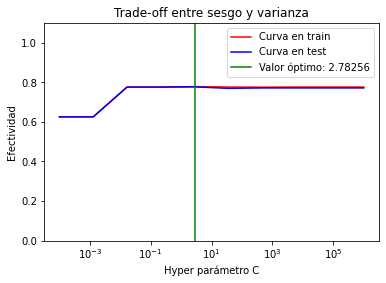

In [13]:
# Gráfica los resultados para todos los valores del hyper parámetro C
# Saca el promedio de los resultados obtenidos en la parte de arriba
train_scores_mean_cv = np.mean(train_scores, axis = 1)
test_scores_mean_cv = np.mean(test_scores, axis = 1)

# Escoge el valor de C tal que:
# Maximice la efectividad en el test de validación
# Minimice la diferencia entre la métrica de efectividad en el set de datos de entrenamiento y validación
choose_index_list = list(np.array(test_scores_mean_cv) - np.abs((np.array(train_scores_mean_cv)-np.array(test_scores_mean_cv))))
choose_index = choose_index_list.index(np.max(choose_index_list))

# Guarda el valor óptimo para C
optimum_parameter = C_values[choose_index]

# Gráfica las curvas de efectividad en el set de datos de train y test
import matplotlib.lines as mlines
def plot_score_metric_train_test(SM_list_train, SM_list_test, param_range,choose_index, value_parameter, symbol_parameter):
    plt.plot(param_range, SM_list_train, color = 'r')
    plt.plot(param_range, SM_list_test, 'b')
    plt.axvline(x = optimum_parameter, color = 'g')
    plt.title('Trade-off entre sesgo y varianza')
    plt.xlabel('Hyper parámetro {0}'.format(symbol_parameter))
    plt.ylabel('Efectividad')
    plt.ylim(0.0, 1.1)
    plt.xscale('log')

    train = mlines.Line2D([], [], color='r', marker='',
                              markersize=15, label='Curva en train')
    test = mlines.Line2D([], [], color='b', marker='',
                              markersize=15, label='Curva en test')
    opt_value = mlines.Line2D([], [], color='g', marker='',
                              markersize=15, label='Valor óptimo: {0:.5f}'.format(value_parameter))
    plt.legend(handles=[train, test, opt_value])
    plt.show()
    
# Gráfica las curvas de performance en cada set de datos
plot_score_metric_train_test(train_scores_mean_cv, test_scores_mean_cv, C_values,choose_index, optimum_parameter, 'C')

In [14]:
# Imprime el mejor valor para C
print("Valor óptimo para C es: {0:.5f}".format(optimum_parameter))

Valor óptimo para C es: 2.78256


In [15]:
# Imprime las métricas de efectividad en train y test para cada valor de C
def print_cv_validation_scores(parameter, train_accu_mean_scores, test_accu_mean_scores): 
    dash = '-' * 100
    print(dash)
    print('{:<30s}{:<35s}{:<25s}'.format('Valor de Hyper parámetro','Efectividad media en train', 'Efectividad media en test'))
    print(dash)
    for i in range(len(parameter)):
        print('{:<30.4f}{:<35.3f}{:<25.3f}'.format(parameter[i], train_accu_mean_scores[i], test_accu_mean_scores[i]))
    print(dash)

print_cv_validation_scores(C_values, train_scores_mean_cv, test_scores_mean_cv)

----------------------------------------------------------------------------------------------------
Valor de Hyper parámetro      Efectividad media en train         Efectividad media en test
----------------------------------------------------------------------------------------------------
0.0001                        0.626                              0.626                    
0.0013                        0.626                              0.626                    
0.0167                        0.776                              0.776                    
0.2154                        0.776                              0.776                    
2.7826                        0.778                              0.777                    
35.9381                       0.776                              0.770                    
464.1589                      0.776                              0.772                    
5994.8425                     0.776                              0.772

In [16]:
# Entrena un modelo final con el hyper parámetro C óptimo
pipeline.set_params(logit_model_l2__C = optimum_parameter)
logit_model_l2 = pipeline.named_steps['logit_model_l2'] 
logit_model_l2.fit(X_train,y_train)
accu_logit_model_l2 = logit_model_l2.score(X_test,y_test)
print ("Efectividad del modelo: {0:.2f}%".format(100*accu_logit_model_l2))

Efectividad del modelo: 79.13%


In [17]:
# Haz una predicción
y_pred_logit = logit_model_l2.predict(X_test)
y_pred_proba_logit = logit_model_l2.predict_proba(X_test)

# Errores = 82.0000
% Erroress = 0.2087
# Aciertos = 311.0000
% Efectividad = 0.7913
Otra forma de calcular la efectividad = 0.7913
% Recall = 0.7006
% Precisión = 0.7586


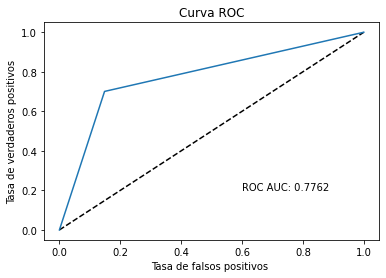

In [18]:
# Calcula métricas de performance de un modelo
matriz_confusion_logit = confusion_matrix(y_test, y_pred_logit)  

# Cuántos errores cometimos?
error_logit = matriz_confusion_logit[0][1] + matriz_confusion_logit[1][0]
print('# Errores = {0:.4f}'.format(error_logit))
print('% Erroress = {0:.4f}'.format(error_logit/len(y_pred_logit)))

# Calcula la efectividad
efectividad_logit = matriz_confusion_logit[0][0] + matriz_confusion_logit[1][1]
print('# Aciertos = {0:.4f}'.format(efectividad_logit))
print('% Efectividad = {0:.4f}'.format(efectividad_logit/len(y_pred_logit)))
print('Otra forma de calcular la efectividad = {0:.4f}'.format(1-(error_logit/len(y_pred_logit))))

# Calcula el recall y la precisión de la predicción
recall_logit = matriz_confusion_logit[1][1]/(matriz_confusion_logit[1][1] + matriz_confusion_logit[1][0])
precision_logit = matriz_confusion_logit[1][1]/(matriz_confusion_logit[1][1] + matriz_confusion_logit[0][1])
print('% Recall = {0:.4f}'.format(recall_logit))
print('% Precisión = {0:.4f}'.format(precision_logit))

# Calcula la tasa de falsos positivos y la tasa de verdaderos positivos para poder graficar la curva ROC, y para calcular la métrica ROC AUC
fpr_logit, tpr_logit, _ = roc_curve(y_test, y_pred_logit)
auc_logit = roc_auc_score(y_test, y_pred_logit)
grafica_curva_roc(fpr_logit, tpr_logit, 'Curva ROC', note='ROC AUC: {0:.4f}'.format(auc_logit))

## Entrena modelos ensamble

### Bosque aleatorio

In [19]:
# Utiliza el siguiente espacio para los valores que puede tomar el hyper parámetro n
n_values = [10, 50, 150, 200, 250]

In [20]:
# 3-Fold CV
cv_schema = StratifiedKFold(n_splits=3, random_state=SEED, shuffle = True)
N_JOBS = -1

# Define un pipeline con toda la información del modelo
estimators = []
estimators.append(('standardize', StandardScaler()))
estimators.append(('forest_model', RandomForestClassifier()))
pipeline = Pipeline(estimators)
pipeline.set_params(forest_model__random_state=SEED)
pipeline

# Utiliza la función validation_curve para entrenar y validar varios modelos (tantos como valores para el hyper parámetro n)
train_scores, test_scores = validation_curve(pipeline, X_train, y_train, 
                                              param_name = 'forest_model__n_estimators', 
                                              param_range  = n_values, 
                                              cv = cv_schema, scoring = 'accuracy', n_jobs = N_JOBS)

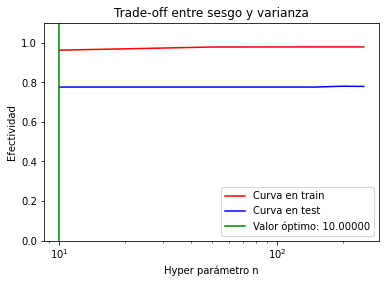

In [21]:
# Gráfica los resultados para todos los valores del hyper parámetro n
# Saca el promedio de los resultados obtenidos en la parte de arriba
train_scores_mean_cv = np.mean(train_scores, axis = 1)
test_scores_mean_cv = np.mean(test_scores, axis = 1)

# Escoge el valor de n tal que:
# Maximice la efectividad en el test de validación
# Minimice la diferencia entre la métrica de efectividad en el set de datos de entrenamiento y validación
choose_index_list = list(np.array(test_scores_mean_cv) - np.abs((np.array(train_scores_mean_cv)-np.array(test_scores_mean_cv))))
choose_index = choose_index_list.index(np.max(choose_index_list))

# Guarda el valor óptimo para n 
optimum_parameter = n_values[choose_index]

# Gráfica las curvas de efectividad en el set de datos de train y test
import matplotlib.lines as mlines
def plot_score_metric_train_test(SM_list_train, SM_list_test, param_range,choose_index, value_parameter, symbol_parameter):
    plt.plot(param_range, SM_list_train, color = 'r')
    plt.plot(param_range, SM_list_test, 'b')
    plt.axvline(x = optimum_parameter, color = 'g')
    plt.title('Trade-off entre sesgo y varianza')
    plt.xlabel('Hyper parámetro {0}'.format(symbol_parameter))
    plt.ylabel('Efectividad')
    plt.ylim(0.0, 1.1)
    plt.xscale('log')

    train = mlines.Line2D([], [], color='r', marker='',
                              markersize=15, label='Curva en train')
    test = mlines.Line2D([], [], color='b', marker='',
                              markersize=15, label='Curva en test')
    opt_value = mlines.Line2D([], [], color='g', marker='',
                              markersize=15, label='Valor óptimo: {0:.5f}'.format(value_parameter))
    plt.legend(handles=[train, test, opt_value])
    plt.show()
    
# Gráfica las curvas de performance en cada set de datos
plot_score_metric_train_test(train_scores_mean_cv, test_scores_mean_cv, n_values,choose_index, optimum_parameter, 'n')

In [22]:
# Imprime el mejor valor para n
print("Valor óptimo para n es: {0:.5f}".format(optimum_parameter))

Valor óptimo para n es: 10.00000


In [23]:
# Imprime las métricas de efectividad en train y test para cada valor de C
def print_cv_validation_scores(parameter, train_accu_mean_scores, test_accu_mean_scores): 
    dash = '-' * 100
    print(dash)
    print('{:<30s}{:<35s}{:<25s}'.format('Valor de Hyper parámetro','Efectividad media en train', 'Efectividad media en test'))
    print(dash)
    for i in range(len(parameter)):
        print('{:<30.4f}{:<35.3f}{:<25.3f}'.format(parameter[i], train_accu_mean_scores[i], test_accu_mean_scores[i]))
    print(dash)

print_cv_validation_scores(n_values, train_scores_mean_cv, test_scores_mean_cv)

----------------------------------------------------------------------------------------------------
Valor de Hyper parámetro      Efectividad media en train         Efectividad media en test
----------------------------------------------------------------------------------------------------
10.0000                       0.963                              0.776                    
50.0000                       0.979                              0.776                    
150.0000                      0.979                              0.776                    
200.0000                      0.979                              0.781                    
250.0000                      0.979                              0.780                    
----------------------------------------------------------------------------------------------------


In [24]:
# Entrena un modelo final con el hyper parámetro n óptimo
pipeline.set_params(forest_model__n_estimators = optimum_parameter)
rf = pipeline.named_steps['forest_model'] 
rf.fit(X_train,y_train)
accu_rf = rf.score(X_test,y_test)
print ("Efectividad del modelo: {0:.2f}%".format(100*accu_rf))

Efectividad del modelo: 79.13%


In [25]:
# Haz una predicción
y_pred_rf = rf.predict(X_test)
y_pred_proba_rf = rf.predict_proba(X_test)

# Errores = 82.0000
% Erroress = 0.2087
# Aciertos = 311.0000
% Efectividad = 0.7913
Otra forma de calcular la efectividad = 0.7913
% Recall = 0.6752
% Precisión = 0.7737


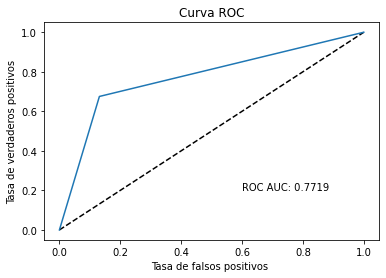

In [26]:
# Calcula métricas de performance de un modelo
matriz_confusion_rf = confusion_matrix(y_test, y_pred_rf)  

# Cuántos errores cometimos?
error_rf = matriz_confusion_rf[0][1] + matriz_confusion_rf[1][0]
print('# Errores = {0:.4f}'.format(error_rf))
print('% Erroress = {0:.4f}'.format(error_rf/len(y_pred_rf)))

# Calcula la efectividad
efectividad_rf = matriz_confusion_rf[0][0] + matriz_confusion_rf[1][1]
print('# Aciertos = {0:.4f}'.format(efectividad_rf))
print('% Efectividad = {0:.4f}'.format(efectividad_rf/len(y_pred_rf)))
print('Otra forma de calcular la efectividad = {0:.4f}'.format(1-(error_rf/len(y_pred_rf))))

# Calcula el recall y la precisión de la predicción
recall_rf = matriz_confusion_rf[1][1]/(matriz_confusion_rf[1][1] + matriz_confusion_rf[1][0])
precision_rf = matriz_confusion_rf[1][1]/(matriz_confusion_rf[1][1] + matriz_confusion_rf[0][1])
print('% Recall = {0:.4f}'.format(recall_rf))
print('% Precisión = {0:.4f}'.format(precision_rf))

# Calcula la tasa de falsos positivos y la tasa de verdaderos positivos para poder graficar la curva ROC, y para calcular la métrica ROC AUC
fpr_rf, tpr_rf, _ = roc_curve(y_test, y_pred_rf)
auc_rf = roc_auc_score(y_test, y_pred_rf)
grafica_curva_roc(fpr_rf, tpr_rf, 'Curva ROC', note='ROC AUC: {0:.4f}'.format(auc_rf))

Para este modelo, determine la importancia de variables

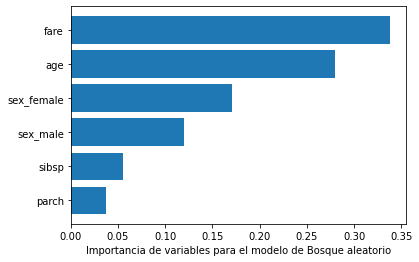

In [27]:
# Utiliza el atributo llamado feature_importances_ del modelo random forest
sorted_idx = rf.feature_importances_.argsort()
plt.barh(X.columns[sorted_idx], rf.feature_importances_[sorted_idx])
plt.xlabel("Importancia de variables para el modelo de Bosque aleatorio")
plt.show()

### Modelo de árboles extra

In [28]:
# Utiliza el siguiente espacio para los valores que puede tomar el hyper parámetro n
n_values = [10, 50, 150, 200, 250]

In [29]:
# 3-Fold CV
cv_schema = StratifiedKFold(n_splits=3, random_state=SEED, shuffle = True)
N_JOBS = -1

# Define un pipeline con toda la información del modelo
estimators = []
estimators.append(('standardize', StandardScaler()))
estimators.append(('extra_trees', ExtraTreesClassifier()))
pipeline = Pipeline(estimators)
pipeline.set_params(extra_trees__random_state=SEED)
pipeline

# Utiliza la función validation_curve para entrenar y validar varios modelos (tantos como valores para el hyper parámetro n)
train_scores, test_scores = validation_curve(pipeline, X_train, y_train, 
                                              param_name = 'extra_trees__n_estimators', 
                                              param_range  = n_values, 
                                              cv = cv_schema, scoring = 'accuracy', n_jobs = N_JOBS)

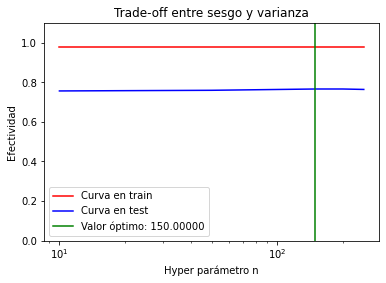

In [30]:
# Gráfica los resultados para todos los valores del hyper parámetro n
# Saca el promedio de los resultados obtenidos en la parte de arriba
train_scores_mean_cv = np.mean(train_scores, axis = 1)
test_scores_mean_cv = np.mean(test_scores, axis = 1)

# Escoge el valor de n tal que:
# Maximice la efectividad en el test de validación
# Minimice la diferencia entre la métrica de efectividad en el set de datos de entrenamiento y validación
choose_index_list = list(np.array(test_scores_mean_cv) - np.abs((np.array(train_scores_mean_cv)-np.array(test_scores_mean_cv))))
choose_index = choose_index_list.index(np.max(choose_index_list))

# Guarda el valor óptimo para n 
optimum_parameter = n_values[choose_index]

# Gráfica las curvas de efectividad en el set de datos de train y test
import matplotlib.lines as mlines
def plot_score_metric_train_test(SM_list_train, SM_list_test, param_range,choose_index, value_parameter, symbol_parameter):
    plt.plot(param_range, SM_list_train, color = 'r')
    plt.plot(param_range, SM_list_test, 'b')
    plt.axvline(x = optimum_parameter, color = 'g')
    plt.title('Trade-off entre sesgo y varianza')
    plt.xlabel('Hyper parámetro {0}'.format(symbol_parameter))
    plt.ylabel('Efectividad')
    plt.ylim(0.0, 1.1)
    plt.xscale('log')

    train = mlines.Line2D([], [], color='r', marker='',
                              markersize=15, label='Curva en train')
    test = mlines.Line2D([], [], color='b', marker='',
                              markersize=15, label='Curva en test')
    opt_value = mlines.Line2D([], [], color='g', marker='',
                              markersize=15, label='Valor óptimo: {0:.5f}'.format(value_parameter))
    plt.legend(handles=[train, test, opt_value])
    plt.show()
    
# Gráfica las curvas de performance en cada set de datos
plot_score_metric_train_test(train_scores_mean_cv, test_scores_mean_cv, n_values,choose_index, optimum_parameter, 'n')

In [31]:
# Imprime el mejor valor para n
print("Valor óptimo para n es: {0:.5f}".format(optimum_parameter))

Valor óptimo para n es: 150.00000


In [32]:
# Imprime las métricas de efectividad en train y test para cada valor de C
def print_cv_validation_scores(parameter, train_accu_mean_scores, test_accu_mean_scores): 
    dash = '-' * 100
    print(dash)
    print('{:<30s}{:<35s}{:<25s}'.format('Valor de Hyper parámetro','Efectividad media en train', 'Efectividad media en test'))
    print(dash)
    for i in range(len(parameter)):
        print('{:<30.4f}{:<35.3f}{:<25.3f}'.format(parameter[i], train_accu_mean_scores[i], test_accu_mean_scores[i]))
    print(dash)

print_cv_validation_scores(n_values, train_scores_mean_cv, test_scores_mean_cv)

----------------------------------------------------------------------------------------------------
Valor de Hyper parámetro      Efectividad media en train         Efectividad media en test
----------------------------------------------------------------------------------------------------
10.0000                       0.979                              0.757                    
50.0000                       0.979                              0.760                    
150.0000                      0.979                              0.766                    
200.0000                      0.979                              0.766                    
250.0000                      0.979                              0.764                    
----------------------------------------------------------------------------------------------------


In [33]:
# Entrena un modelo final con el hyper parámetro C óptimo
pipeline.set_params(extra_trees__n_estimators = optimum_parameter)
extra = pipeline.named_steps['extra_trees'] 
extra.fit(X_train,y_train)
accu_extra = extra.score(X_test,y_test)
print ("Efectividad del modelo: {0:.2f}%".format(100*accu_extra))

Efectividad del modelo: 77.86%


In [34]:
# Haz una predicción
y_pred_extra =extra.predict(X_test)
y_pred_proba_extra =extra.predict_proba(X_test)

# Errores = 87.0000
% Erroress = 0.2214
# Aciertos = 306.0000
% Efectividad = 0.7786
Otra forma de calcular la efectividad = 0.7786
% Recall = 0.6879
% Precisión = 0.7397


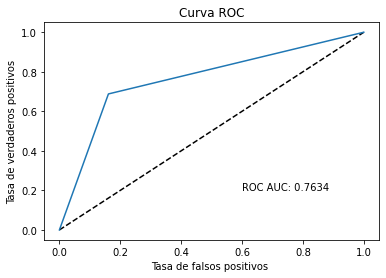

In [35]:
# Calcula métricas de performance de un modelo
matriz_confusion_extra = confusion_matrix(y_test, y_pred_extra)  

# Cuántos errores cometimos?
error_extra = matriz_confusion_extra[0][1] + matriz_confusion_extra[1][0]
print('# Errores = {0:.4f}'.format(error_extra))
print('% Erroress = {0:.4f}'.format(error_extra/len(y_pred_extra)))

# Calcula la efectividad
efectividad_extra = matriz_confusion_extra[0][0] + matriz_confusion_extra[1][1]
print('# Aciertos = {0:.4f}'.format(efectividad_extra))
print('% Efectividad = {0:.4f}'.format(efectividad_extra/len(y_pred_extra)))
print('Otra forma de calcular la efectividad = {0:.4f}'.format(1-(error_extra/len(y_pred_extra))))

# Calcula el recall y la precisión de la predicción
recall_extra = matriz_confusion_extra[1][1]/(matriz_confusion_extra[1][1] + matriz_confusion_extra[1][0])
precision_extra = matriz_confusion_extra[1][1]/(matriz_confusion_extra[1][1] + matriz_confusion_extra[0][1])
print('% Recall = {0:.4f}'.format(recall_extra))
print('% Precisión = {0:.4f}'.format(precision_extra))

# Calcula la tasa de falsos positivos y la tasa de verdaderos positivos para poder graficar la curva ROC, y para calcular la métrica ROC AUC
fpr_extra, tpr_extra, _ = roc_curve(y_test, y_pred_extra)
auc_extra = roc_auc_score(y_test, y_pred_extra)
grafica_curva_roc(fpr_extra, tpr_extra, 'Curva ROC', note='ROC AUC: {0:.4f}'.format(auc_extra))

Para este modelo, determine la importancia de variables también

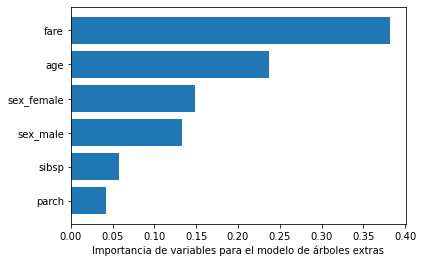

In [36]:
# Utiliza el atributo llamado feature_importances_ del modelo random forest
sorted_idx = extra.feature_importances_.argsort()
plt.barh(X.columns[sorted_idx], extra.feature_importances_[sorted_idx])
plt.xlabel("Importancia de variables para el modelo de árboles extras")
plt.show()

## Compara los modelos

In [37]:
# Agrega las métricas del modelo ensamble
classifiers = ['logit_model_l2', 'rf', 'extra trees']
accuracy = [efectividad_logit/len(y_pred_logit), efectividad_rf/len(y_pred_rf), efectividad_extra/len(y_pred_extra)]
roc_auc = [auc_logit, auc_rf, auc_extra]
recall = [recall_logit, recall_rf, recall_extra]
precision = [precision_logit, precision_rf, precision_extra]

# Imprime tabla de resultados
print_metrics(classifiers, accuracy, roc_auc, recall, precision)

--------------------------------------------------------------------------------
Clasificador        Efectividad    ROC AUC        recall         precision      
--------------------------------------------------------------------------------
logit_model_l2      0.791          0.776          0.701          0.759          
rf                  0.791          0.772          0.675          0.774          
extra trees         0.779          0.763          0.688          0.740          
--------------------------------------------------------------------------------


In [38]:
## Selecciona el mejor modelo utilizando bootstrap
num_records = y.shape[0]
bootstrap_errors_logit_model_l2 = []
bootstrap_errors_rf = []
bootstrap_errors_extra = []
for i in range(1000):
    train_indices = np.random.choice(range(num_records), num_records, replace=True)
    test_indices = np.setdiff1d(range(num_records), train_indices)
    X_train_b, y_train_b = np.array(X)[train_indices], y[train_indices]
    X_test_b, y_test_b = np.array(X)[test_indices], y[test_indices]
    
    # Logit model L2
    logit_model_l2.fit(X_train_b, y_train_b)
    bootstrap_errors_logit_model_l2.append(roc_auc_score(y_test_b, logit_model_l2.predict(X_test_b)))
    
    # RF model
    rf.fit(X_train_b, y_train_b)
    bootstrap_errors_rf.append(roc_auc_score(y_test_b, rf.predict(X_test_b)))
    
    # Extra trees
    extra.fit(X_train_b, y_train_b)
    bootstrap_errors_extra.append(roc_auc_score(y_test_b, extra.predict(X_test_b)))
    
bootstrap_errors_sorted_logit_model_l2 = np.sort(bootstrap_errors_logit_model_l2)
bootstrap_errors_sorted_rf = np.sort(bootstrap_errors_rf)
bootstrap_errors_sorted_extra = np.sort(bootstrap_errors_extra)

mean_error_rf = bootstrap_errors_sorted_rf.mean()
mean_error_logit_model_l2 = bootstrap_errors_sorted_logit_model_l2.mean()
mean_error_extra = bootstrap_errors_sorted_extra.mean()

errors = [mean_error_rf, mean_error_logit_model_l2, mean_error_extra]

deviation_rf = bootstrap_errors_sorted_rf - mean_error_rf
deviation_logit_model_l2 = bootstrap_errors_sorted_logit_model_l2 - mean_error_logit_model_l2
deviation_extra = bootstrap_errors_sorted_extra - mean_error_extra

print('95% CIs')
print('RF: [{:f}, {:f}], con media: {:f}'.format(bootstrap_errors_sorted_rf[25], bootstrap_errors_sorted_rf[975], mean_error_rf))
print('logit_model_l2: [{:f}, {:f}], con media: {:f}'.format(bootstrap_errors_sorted_logit_model_l2[25], bootstrap_errors_sorted_logit_model_l2[975], mean_error_logit_model_l2))
print('Extra Trees: [{:f}, {:f}], con media: {:f}'.format(bootstrap_errors_sorted_extra[25], bootstrap_errors_sorted_extra[975], mean_error_extra))

95% CIs
Knn: [0.703547, 0.774777], con media: 0.740829
logit_model_l2: [0.729695, 0.790746], con media: 0.760560
Extra Trees: [0.706091, 0.771177], con media: 0.739288


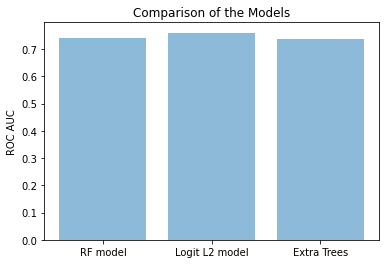

In [39]:
# grafica resultados
xpos = np.arange(len(errors))
plt.bar(xpos, errors, align='center', alpha=0.5, ecolor='black', capsize=10)
plt.xticks(xpos, ('RF model', 'Logit L2 model', 'Extra Trees'))
plt.ylabel('ROC AUC')
plt.title('Comparison of the Models')
plt.show()

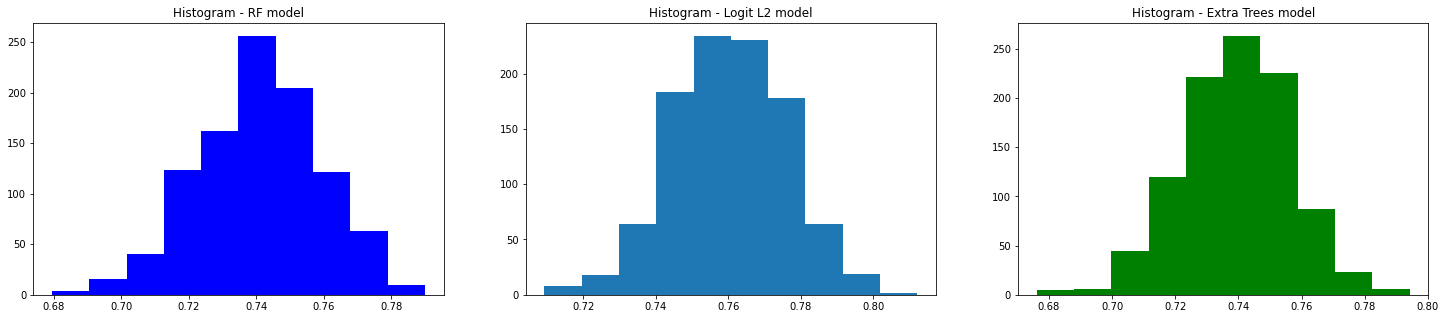

In [40]:
# Checa si los resultados tienen una distribución simétrica
fig, ax = plt.subplots(1,3,figsize=(25,5))
ax[0].hist(bootstrap_errors_sorted_rf, color = 'b')
ax[0].set_title("Histogram - {}".format('RF model'))

ax[1].hist(bootstrap_errors_sorted_logit_model_l2)
ax[1].set_title("Histogram - {}".format('Logit L2 model'))

ax[2].hist(bootstrap_errors_sorted_extra, color = 'green')
ax[2].set_title("Histogram - {}".format('Extra Trees model'))

plt.show()